In [ ]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from SimpleDeepESN import *
from IPython.display import display, clear_output

def train(self,train_x,train_y,i): # allena il readout dell'i-esimo reservoir
  s = np.array( list( esn.compute_state(d)[i] for d in train_x ) ) #shape ( len(data) , esn.N , esn.Nr , 1 )
  s = s.reshape( np.size(train_x) , self.Nr )
  d = train_y.T #shape(len(data),Nr)
  self.ress[i].Wout = np.transpose( np.dot( np.linalg.pinv(s) , d ) )

def MC(esn,i,data):
  for d in data[:1000]:
    esn.compute_state(d) # washout

  m = np.array( list( esn.compute_output_i(d,i) for d in data[1000:] ) ).reshape(1000,esn.Ny) # matrice degli yk: uno per colonna

  v1 = np.var(data[1000-esn.Ny:])
  MC =(np.cov(m[:,0] , data[1000:])[0,0])**2 / (v1 * np.var(m[:,0])) + sum( (np.cov( m[:,k] , data[1000-k:-k])[0,0])**2 / ( v1 * np.var(m[:,k])) for k in range(1,esn.Ny) )

  if MC > 100 : MC=0
  return MC

def DSS(esn,data):  
  dims = np.zeros(esn.N)
  esn.reset_states()
  c_state = esn.compute_state
  l = np.array( list( map( c_state, data ) ) ) #shape ( len(data) , esn.N , esn.Nr , 1 )
  for j in range( esn.N ):
    m_j = l[:,j,:,:].reshape( np.size(data) , esn.Nr ).T # matrice degli stati assunti dall'i-esimo reservoir
    cov_m=np.cov(m_j)
    eigs= np.linalg.eigvalsh(cov_m)
    dims[j] = np.sum(eigs)**2/np.sum(np.square(eigs)) 
  return dims

def train_both(esn,i,train_seq,steps):
  esn.reset_states()
  in_step = steps[0]
  rec_step = steps[1]
  res = esn.ress[i]
  W_in = res.W_in ; D_in = res.D_in
  W = res.W       ; D = res.D
  if i>0:  
    for el in train_seq:
      p = esn.ress[i-1].x # preattivazione per matrice input e' lo stato del reservoir precedente al tempo t
      pin = np.vstack((p,1)) # completa di bias
      preact = res.x # invece la preattivazione per matrice ricorrente e' lo stato di questo reservoir al tempo t.
      act= esn.compute_state(el)[i] # l'attivazione post-sinaptica invece e' data dallo stato di questo reservoir al tempo t+1
      W_in += np.multiply( compute_weights( W_in, pin , act , in_step) , D_in )
      W += np.multiply( compute_weights( W , preact , act , rec_step ) , D ) 
  else:
    for el in train_seq:
      pin = np.vstack((el,1)) # per quanto riguarda il primo reservoir la preattivazione consiste nell'input corrente
      preact = res.x # invece la preattivazione per matrice ricorrente e' lo stato di questo reservoir al tempo t.
      act = res.compute_state(el) # in questo caso non ho bisogno di far passare il flusso per tutta la rete!
      W_in += np.multiply( compute_weights( W_in, pin , act , in_step) , D_in )
      W += np.multiply( compute_weights( W , preact , act , rec_step ) , D ) 

def train_input(esn,i,train_seq,in_step):
  esn.reset_states()
  res = esn.ress[i]
  W_in = res.W_in ; D_in = res.D_in
  if i>0:  
    for el in train_seq:
      p = esn.ress[i-1].x # preattivazione per matrice input e' lo stato del reservoir precedente al tempo t
      pin = np.vstack((p,1)) # completa di bias
      act= esn.compute_state(el)[i] # l'attivazione post-sinaptica invece e' data dallo stato di questo reservoir al tempo t+1
      W_in += np.multiply( compute_weights( W_in, pin , act , in_step) , D_in )
  else:
    for el in train_seq:
      pin = np.vstack((el,1)) # per quanto riguarda il primo reservoir la preattivazione consiste nell'input corrente
      act = res.compute_state(el) # in questo caso non ho bisogno di far passare il flusso per tutta la rete!
      W_in += np.multiply( compute_weights( W_in, pin , act , in_step) , D_in )


def train_rec(esn,i,train_seq,rec_step):
  esn.reset_states()
  res = esn.ress[i]
  W = res.W       ; D = res.D
  if i>0:  
    for el in train_seq:
      preact = res.x # invece la preattivazione per matrice ricorrente e' lo stato di questo reservoir al tempo t.
      act= esn.compute_state(el)[i] # l'attivazione post-sinaptica invece e' data dallo stato di questo reservoir al tempo t+1
      W += np.multiply( compute_weights( W , preact , act , rec_step ) , D ) 
  else:
    for el in train_seq:
      preact = res.x # invece la preattivazione per matrice ricorrente e' lo stato di questo reservoir al tempo t.
      act = res.compute_state(el) # in questo caso non ho bisogno di far passare il flusso per tutta la rete!
      W += np.multiply( compute_weights( W , preact , act , rec_step ) , D ) 




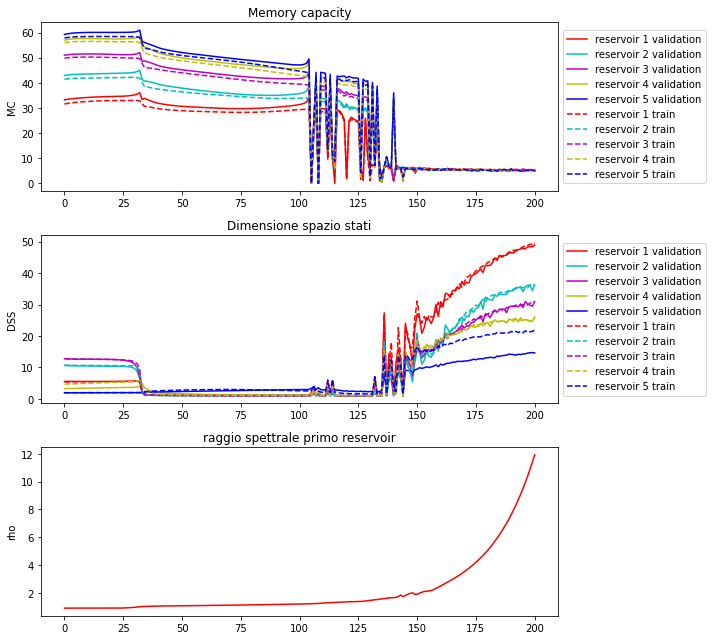

In [ ]:
train_data= 0.5*(2*np.random.rand(5000)-1)
test_data= 0.5*(2*np.random.rand(2000)-1)

train_x = train_data[1000:5000]
train_y = np.vstack( list( train_data[1000-k:5000-k] for k in range(200) ) )

max_epochs=200; step=[1e-05,-1e-05] ; train_fun=train_both

esn = DeepESN( N=5, Nr=100, Ny=200 , rho=0.9 , r_density=0.8 , i_density=1 )

for i in range(esn.N):
  for d in train_data[:1000]:
    esn.compute_state(d) # washout
  train(esn,train_x,train_y,i)  #alleno i-esimo readout

test_dims = np.array( DSS(esn,test_data ) )
test_MCs = np.array( list( MC(esn,i,test_data ) for i in range(esn.N) ) )

train_dims = np.array( DSS(esn,train_data ) )
train_MCs = np.array( list( MC(esn,i,train_data[:2000] ) for i in range(esn.N) ) )

rhos = np.array( max(np.abs(np.linalg.eigvals(esn.ress[0].W))) )

print(test_MCs)

for i in range( 1 ):
  
  print('res:', i )
  for epch in range(max_epochs):
    print(epch,rhos)
    train_fun(esn,i,train_data,step)
    
    for j in range(esn.N):
      for d in train_data[:1000]:
        esn.compute_state(d) # washout
      train(esn,train_x,train_y,j)  

    test_MCs = np.vstack( ( test_MCs, np.array( list( MC(esn,i,test_data ) for i in range(esn.N) ) ) ) )
    test_dims = np.vstack( ( test_dims, DSS(esn,test_data) ) )

    train_MCs = np.vstack( ( train_MCs, np.array( list( MC(esn,i,train_data[:2000] ) for i in range(esn.N) ) ) ) )
    train_dims = np.vstack( ( train_dims, DSS(esn,train_data) ) )

    rhos = np.vstack( ( rhos, max(np.abs(np.linalg.eigvals(esn.ress[0].W))) ) )

  clear_output()


fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(10,9))

ax1.set_ylabel('MC') ; ax1.title.set_text('Memory capacity'); 
ax2.set_ylabel('DSS') ; ax2.title.set_text('Dimensione spazio stati')
ax3.set_ylabel('rho') ; ax3.title.set_text('raggio spettrale primo reservoir')

ax1.plot(test_MCs[:,0],'-r') ;ax1.plot(test_MCs[:,1],'-c') ;ax1.plot(test_MCs[:,2],'-m') 
ax1.plot(test_MCs[:,3],'-y') ;ax1.plot(test_MCs[:,4],'-b') 

ax1.plot(train_MCs[:,0],'--r') ;ax1.plot(train_MCs[:,1],'--c') ;ax1.plot(train_MCs[:,2],'--m') 
ax1.plot(train_MCs[:,3],'--y') ;ax1.plot(train_MCs[:,4],'--b') 

ax1.legend(['reservoir 1 validation','reservoir 2 validation','reservoir 3 validation','reservoir 4 validation','reservoir 5 validation','reservoir 1 train','reservoir 2 train','reservoir 3 train','reservoir 4 train','reservoir 5 train',],loc='center left', bbox_to_anchor=(1, 0.5))

ax2.plot(test_dims[:,0],'-r') ;ax2.plot(test_dims[:,1],'-c') ;ax2.plot(test_dims[:,2],'-m') ;
ax2.plot(test_dims[:,3],'-y') ;ax2.plot(test_dims[:,4],'-b') 

ax2.plot(train_dims[:,0],'--r') ;ax2.plot(train_dims[:,1],'--c') ;ax2.plot(train_dims[:,2],'--m') ;
ax2.plot(train_dims[:,3],'--y') ;ax2.plot(train_dims[:,4],'--b') 

ax2.legend(['reservoir 1 validation','reservoir 2 validation','reservoir 3 validation','reservoir 4 validation','reservoir 5 validation', 'reservoir 1 train','reservoir 2 train','reservoir 3 train','reservoir 4 train','reservoir 5 train',],loc='center left', bbox_to_anchor=(1, 0.5))

ax3.plot( rhos[:,0],'-r')


fig.tight_layout()


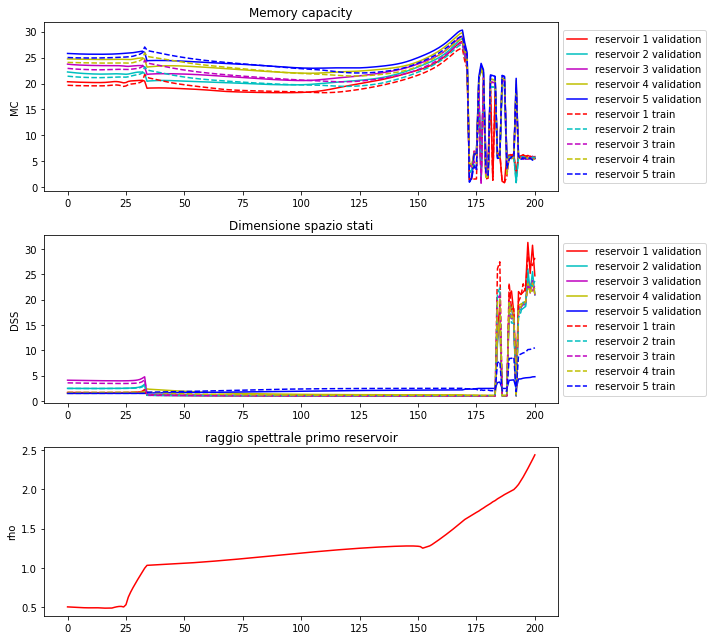

In [ ]:
train_data= 0.5*(2*np.random.rand(5000)-1)
test_data= 0.5*(2*np.random.rand(2000)-1)

train_x = train_data[1000:5000]
train_y = np.vstack( list( train_data[1000-k:5000-k] for k in range(200) ) )

max_epochs=200; step=[1e-05,-1e-05] ; train_fun=train_both

esn = DeepESN( N=5, Nr=100, Ny=200 , rho=0.5 , r_density=0.8 , i_density=1 )

for i in range(esn.N):
  for d in train_data[:1000]:
    esn.compute_state(d) # washout
  train(esn,train_x,train_y,i)  #alleno i-esimo readout

test_dims = np.array( DSS(esn,test_data ) )
test_MCs = np.array( list( MC(esn,i,test_data ) for i in range(esn.N) ) )

train_dims = np.array( DSS(esn,train_data ) )
train_MCs = np.array( list( MC(esn,i,train_data[:2000] ) for i in range(esn.N) ) )

rhos = np.array( max(np.abs(np.linalg.eigvals(esn.ress[0].W))) )

print(test_MCs)

for i in range( 1 ):
  
  print('res:', i )
  for epch in range(max_epochs):
    print(epch,rhos)
    train_fun(esn,i,train_data,step)
    
    for j in range(esn.N):
      for d in train_data[:1000]:
        esn.compute_state(d) # washout
      train(esn,train_x,train_y,j)  

    test_MCs = np.vstack( ( test_MCs, np.array( list( MC(esn,i,test_data ) for i in range(esn.N) ) ) ) )
    test_dims = np.vstack( ( test_dims, DSS(esn,test_data) ) )

    train_MCs = np.vstack( ( train_MCs, np.array( list( MC(esn,i,train_data[:2000] ) for i in range(esn.N) ) ) ) )
    train_dims = np.vstack( ( train_dims, DSS(esn,train_data) ) )

    rhos = np.vstack( ( rhos, max(np.abs(np.linalg.eigvals(esn.ress[0].W))) ) )

  clear_output()


fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(10,9))

ax1.set_ylabel('MC') ; ax1.title.set_text('Memory capacity'); 
ax2.set_ylabel('DSS') ; ax2.title.set_text('Dimensione spazio stati')
ax3.set_ylabel('rho') ; ax3.title.set_text('raggio spettrale primo reservoir')

ax1.plot(test_MCs[:,0],'-r') ;ax1.plot(test_MCs[:,1],'-c') ;ax1.plot(test_MCs[:,2],'-m') 
ax1.plot(test_MCs[:,3],'-y') ;ax1.plot(test_MCs[:,4],'-b') 

ax1.plot(train_MCs[:,0],'--r') ;ax1.plot(train_MCs[:,1],'--c') ;ax1.plot(train_MCs[:,2],'--m') 
ax1.plot(train_MCs[:,3],'--y') ;ax1.plot(train_MCs[:,4],'--b') 

ax1.legend(['reservoir 1 validation','reservoir 2 validation','reservoir 3 validation','reservoir 4 validation','reservoir 5 validation','reservoir 1 train','reservoir 2 train','reservoir 3 train','reservoir 4 train','reservoir 5 train',],loc='center left', bbox_to_anchor=(1, 0.5))

ax2.plot(test_dims[:,0],'-r') ;ax2.plot(test_dims[:,1],'-c') ;ax2.plot(test_dims[:,2],'-m') ;
ax2.plot(test_dims[:,3],'-y') ;ax2.plot(test_dims[:,4],'-b') 

ax2.plot(train_dims[:,0],'--r') ;ax2.plot(train_dims[:,1],'--c') ;ax2.plot(train_dims[:,2],'--m') ;
ax2.plot(train_dims[:,3],'--y') ;ax2.plot(train_dims[:,4],'--b') 

ax2.legend(['reservoir 1 validation','reservoir 2 validation','reservoir 3 validation','reservoir 4 validation','reservoir 5 validation', 'reservoir 1 train','reservoir 2 train','reservoir 3 train','reservoir 4 train','reservoir 5 train',],loc='center left', bbox_to_anchor=(1, 0.5))

ax3.plot( rhos[:,0],'-r')


fig.tight_layout()


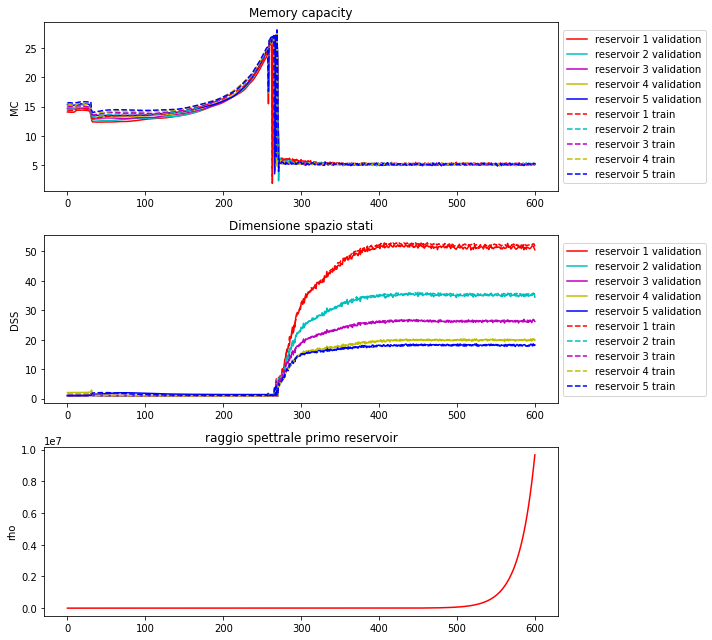

In [ ]:
train_data= 0.5*(2*np.random.rand(5000)-1)
test_data= 0.5*(2*np.random.rand(2000)-1)

train_x = train_data[1000:5000]
train_y = np.vstack( list( train_data[1000-k:5000-k] for k in range(200) ) )

max_epochs=600; step=[1e-05,-1e-05] ; train_fun=train_both

esn = DeepESN( N=5, Nr=100, Ny=200 , rho=0.1 , r_density=0.8 , i_density=1 )

for i in range(esn.N):
  for d in train_data[:1000]:
    esn.compute_state(d) # washout
  train(esn,train_x,train_y,i)  #alleno i-esimo readout

test_dims = np.array( DSS(esn,test_data ) )
test_MCs = np.array( list( MC(esn,i,test_data ) for i in range(esn.N) ) )

train_dims = np.array( DSS(esn,train_data ) )
train_MCs = np.array( list( MC(esn,i,train_data[:2000] ) for i in range(esn.N) ) )

rhos = np.array( max(np.abs(np.linalg.eigvals(esn.ress[0].W))) )

print(test_MCs)

for i in range( 1 ):
  
  print('res:', i )
  for epch in range(max_epochs):
    print(epch,rhos)
    train_fun(esn,i,train_data,step)
    
    for j in range(esn.N):
      for d in train_data[:1000]:
        esn.compute_state(d) # washout
      train(esn,train_x,train_y,j)  

    test_MCs = np.vstack( ( test_MCs, np.array( list( MC(esn,i,test_data ) for i in range(esn.N) ) ) ) )
    test_dims = np.vstack( ( test_dims, DSS(esn,test_data) ) )

    train_MCs = np.vstack( ( train_MCs, np.array( list( MC(esn,i,train_data[:2000] ) for i in range(esn.N) ) ) ) )
    train_dims = np.vstack( ( train_dims, DSS(esn,train_data) ) )

    rhos = np.vstack( ( rhos, max(np.abs(np.linalg.eigvals(esn.ress[0].W))) ) )

  clear_output()


fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(10,9))

ax1.set_ylabel('MC') ; ax1.title.set_text('Memory capacity'); 
ax2.set_ylabel('DSS') ; ax2.title.set_text('Dimensione spazio stati')
ax3.set_ylabel('rho') ; ax3.title.set_text('raggio spettrale primo reservoir')

ax1.plot(test_MCs[:,0],'-r') ;ax1.plot(test_MCs[:,1],'-c') ;ax1.plot(test_MCs[:,2],'-m') 
ax1.plot(test_MCs[:,3],'-y') ;ax1.plot(test_MCs[:,4],'-b') 

ax1.plot(train_MCs[:,0],'--r') ;ax1.plot(train_MCs[:,1],'--c') ;ax1.plot(train_MCs[:,2],'--m') 
ax1.plot(train_MCs[:,3],'--y') ;ax1.plot(train_MCs[:,4],'--b') 

ax1.legend(['reservoir 1 validation','reservoir 2 validation','reservoir 3 validation','reservoir 4 validation','reservoir 5 validation','reservoir 1 train','reservoir 2 train','reservoir 3 train','reservoir 4 train','reservoir 5 train',],loc='center left', bbox_to_anchor=(1, 0.5))

ax2.plot(test_dims[:,0],'-r') ;ax2.plot(test_dims[:,1],'-c') ;ax2.plot(test_dims[:,2],'-m') ;
ax2.plot(test_dims[:,3],'-y') ;ax2.plot(test_dims[:,4],'-b') 

ax2.plot(train_dims[:,0],'--r') ;ax2.plot(train_dims[:,1],'--c') ;ax2.plot(train_dims[:,2],'--m') ;
ax2.plot(train_dims[:,3],'--y') ;ax2.plot(train_dims[:,4],'--b') 

ax2.legend(['reservoir 1 validation','reservoir 2 validation','reservoir 3 validation','reservoir 4 validation','reservoir 5 validation', 'reservoir 1 train','reservoir 2 train','reservoir 3 train','reservoir 4 train','reservoir 5 train',],loc='center left', bbox_to_anchor=(1, 0.5))

ax3.plot( rhos[:,0],'-r')


fig.tight_layout()


[29.9835861  39.07817114 46.53741169 53.58556625 58.62710771]
res: 0
res: 1
res: 2
res: 3
res: 4


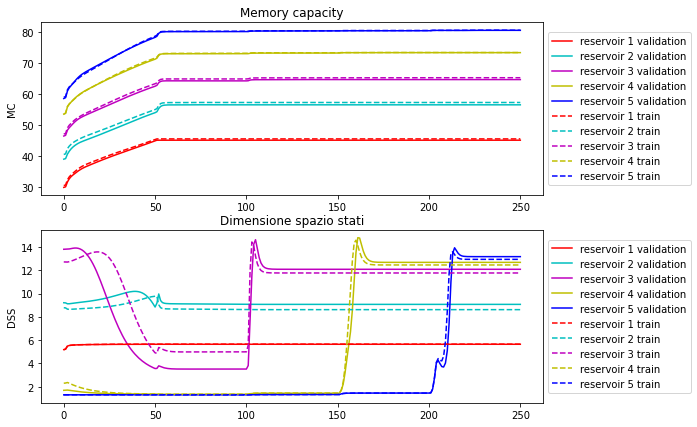

In [ ]:
train_data= 0.5*(2*np.random.rand(5000)-1)
test_data= 0.5*(2*np.random.rand(2000)-1)

train_x = train_data[1000:5000]
train_y = np.vstack( list( train_data[1000-k:5000-k] for k in range(200) ) )

max_epochs=500; step=-1e-05 ; train_fun=train_input ; mesure_interval = 10

esn = DeepESN( N=5, Nr=100, Ny=200 , rho=0.9 , r_density=0.1 , i_density=0.2 )

for i in range(esn.N):
  for d in train_data[:1000]:
    esn.compute_state(d) # washout
  train(esn,train_x,train_y,i)  #alleno i-esimo readout

test_dims = np.array( DSS(esn,test_data ) )
test_MCs = np.array( list( MC(esn,i,test_data ) for i in range(esn.N) ) )

train_dims = np.array( DSS(esn,train_data ) )
train_MCs = np.array( list( MC(esn,i,train_data[:2000] ) for i in range(esn.N) ) )

print(test_MCs)

for i in range( esn.N ):
  
  print('res:', i )
  for epch in range(max_epochs):

    old_Win = np.copy(esn.ress[i].W_in)

    train_fun(esn,i,train_data,step)
          
    if epch % mesure_interval==0:
      for j in range(esn.N):
        for d in train_data[:1000]:
          esn.compute_state(d) # washout
        train(esn,train_x,train_y,j)

      test_MCs = np.vstack( ( test_MCs, np.array( list( MC(esn,i,test_data ) for i in range(esn.N) ) ) ) )
      test_dims = np.vstack( ( test_dims, DSS(esn,test_data) ) )

      train_MCs = np.vstack( ( train_MCs, np.array( list( MC(esn,i,train_data[:2000] ) for i in range(esn.N) ) ) ) )
      train_dims = np.vstack( ( train_dims, DSS(esn,train_data) ) )

fig, (ax1, ax2) = plt.subplots(2, figsize=(9,7))

ax1.set_ylabel('MC') ; ax1.title.set_text('Memory capacity'); 
ax2.set_ylabel('DSS') ; ax2.title.set_text('Dimensione spazio stati')

ax1.plot(test_MCs[:,0],'-r') ;ax1.plot(test_MCs[:,1],'-c') ;ax1.plot(test_MCs[:,2],'-m') 
ax1.plot(test_MCs[:,3],'-y') ;ax1.plot(test_MCs[:,4],'-b') 

ax1.plot(train_MCs[:,0],'--r') ;ax1.plot(train_MCs[:,1],'--c') ;ax1.plot(train_MCs[:,2],'--m') 
ax1.plot(train_MCs[:,3],'--y') ;ax1.plot(train_MCs[:,4],'--b') 

ax1.legend(['reservoir 1 validation','reservoir 2 validation','reservoir 3 validation','reservoir 4 validation','reservoir 5 validation','reservoir 1 train','reservoir 2 train','reservoir 3 train','reservoir 4 train','reservoir 5 train',],loc='center left', bbox_to_anchor=(1, 0.5))

ax2.plot(test_dims[:,0],'-r') ;ax2.plot(test_dims[:,1],'-c') ;ax2.plot(test_dims[:,2],'-m') ;
ax2.plot(test_dims[:,3],'-y') ;ax2.plot(test_dims[:,4],'-b') 

ax2.plot(train_dims[:,0],'--r') ;ax2.plot(train_dims[:,1],'--c') ;ax2.plot(train_dims[:,2],'--m') ;
ax2.plot(train_dims[:,3],'--y') ;ax2.plot(train_dims[:,4],'--b') 

ax2.legend(['reservoir 1 validation','reservoir 2 validation','reservoir 3 validation','reservoir 4 validation','reservoir 5 validation', 'reservoir 1 train','reservoir 2 train','reservoir 3 train','reservoir 4 train','reservoir 5 train',],loc='center left', bbox_to_anchor=(1, 0.5))



[33.39510827 40.65292961 46.73915908 51.44798663 55.53086366]
res: 0
res: 1
res: 2
res: 3
res: 4


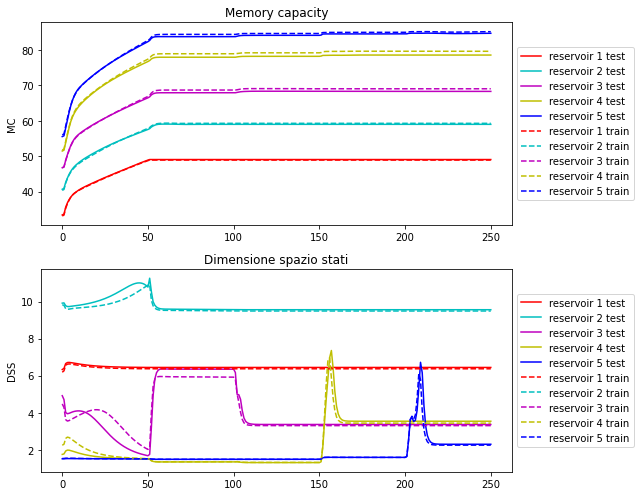

In [ ]:
train_data= 0.5*(2*np.random.rand(5000)-1)
test_data= 0.5*(2*np.random.rand(2000)-1)

train_x = train_data[1000:5000]
train_y = np.vstack( list( train_data[1000-k:5000-k] for k in range(200) ) )

max_epochs=500; step=[-1e-05] ; train_fun=train_both ; mesure_interval = 10

esn = DeepESN( N=5, Nr=100, Ny=200 , rho=0.9 , r_density=0.1 , i_density=0.2 )

for i in range(esn.N):
  for d in train_data[:1000]:
    esn.compute_state(d) # washout
  train(esn,train_x,train_y,i)  #alleno i-esimo readout

test_dims = np.array( DSS(esn,test_data ) )
test_MCs = np.array( list( MC(esn,i,test_data ) for i in range(esn.N) ) )

train_dims = np.array( DSS(esn,train_data ) )
train_MCs = np.array( list( MC(esn,i,train_data[:2000] ) for i in range(esn.N) ) )

print(test_MCs)

for i in range( esn.N ):
  
  print('res:', i )
  for epch in range(max_epochs):

    old_Win = np.copy(esn.ress[i].W_in)

    train_fun(esn,i,train_data,step)
          
    if epch % mesure_interval==0:
      for j in range(esn.N):
        for d in train_data[:1000]:
          esn.compute_state(d) # washout
        train(esn,train_x,train_y,j)

      test_MCs = np.vstack( ( test_MCs, np.array( list( MC(esn,i,test_data ) for i in range(esn.N) ) ) ) )
      test_dims = np.vstack( ( test_dims, DSS(esn,test_data) ) )

      train_MCs = np.vstack( ( train_MCs, np.array( list( MC(esn,i,train_data[:2000] ) for i in range(esn.N) ) ) ) )
      train_dims = np.vstack( ( train_dims, DSS(esn,train_data) ) )


fig, (ax1, ax2) = plt.subplots(2, figsize=(9,7))

ax1.set_ylabel('MC') ; ax1.title.set_text('Memory capacity'); 
ax2.set_ylabel('DSS') ; ax2.title.set_text('Dimensione spazio stati')

ax1.plot(test_MCs[:,0],'-r') ;ax1.plot(test_MCs[:,1],'-c') ;ax1.plot(test_MCs[:,2],'-m') 
ax1.plot(test_MCs[:,3],'-y') ;ax1.plot(test_MCs[:,4],'-b') 

ax1.plot(train_MCs[:,0],'--r') ;ax1.plot(train_MCs[:,1],'--c') ;ax1.plot(train_MCs[:,2],'--m') 
ax1.plot(train_MCs[:,3],'--y') ;ax1.plot(train_MCs[:,4],'--b') 

ax1.legend(['reservoir 1 validation','reservoir 2 validation','reservoir 3 validation','reservoir 4 validation','reservoir 5 validation','reservoir 1 train','reservoir 2 train','reservoir 3 train','reservoir 4 train','reservoir 5 train',],loc='center left', bbox_to_anchor=(1, 0.5))

ax2.plot(test_dims[:,0],'-r') ;ax2.plot(test_dims[:,1],'-c') ;ax2.plot(test_dims[:,2],'-m') ;
ax2.plot(test_dims[:,3],'-y') ;ax2.plot(test_dims[:,4],'-b') 

ax2.plot(train_dims[:,0],'--r') ;ax2.plot(train_dims[:,1],'--c') ;ax2.plot(train_dims[:,2],'--m') ;
ax2.plot(train_dims[:,3],'--y') ;ax2.plot(train_dims[:,4],'--b') 

ax2.legend(['reservoir 1 validation','reservoir 2 validation','reservoir 3 validation','reservoir 4 validation','reservoir 5 validation', 'reservoir 1 train','reservoir 2 train','reservoir 3 train','reservoir 4 train','reservoir 5 train',],loc='center left', bbox_to_anchor=(1, 0.5))


fig.tight_layout()


899
51.101301556283275 51.085846742454834


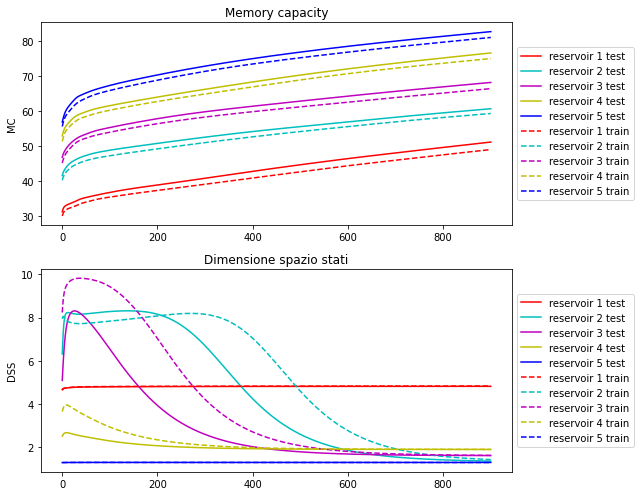

In [ ]:
train_data= 0.5*(2*np.random.rand(5000)-1)
test_data= 0.5*(2*np.random.rand(2000)-1)

train_x = train_data[1000:5000]
train_y = np.vstack( list( train_data[1000-k:5000-k] for k in range(200) ) )

max_epochs=900; step=-1e-05 ; train_fun=train_input

esn = DeepESN( N=5, Nr=100, Ny=200 , rho=0.9 , r_density=0.1 , i_density=0.8 )

for i in range(esn.N):
  for d in train_data[:1000]:
    esn.compute_state(d) # washout
  train(esn,train_x,train_y,i)  #alleno i-esimo readout

test_dims = np.array( DSS(esn,test_data ) )
test_MCs = np.array( list( MC(esn,i,test_data ) for i in range(esn.N) ) )

train_dims = np.array( DSS(esn,train_data ) )
train_MCs = np.array( list( MC(esn,i,train_data[:2000] ) for i in range(esn.N) ) )

print(test_MCs)

for i in range( 1 ):
  
  print('res:', i )
  for epch in range(max_epochs):
    train_fun(esn,i,train_data,step)
    
    for j in range(esn.N):
      for d in train_data[:1000]:
        esn.compute_state(d) # washout
      train(esn,train_x,train_y,j)  

    test_MCs = np.vstack( ( test_MCs, np.array( list( MC(esn,i,test_data ) for i in range(esn.N) ) ) ) )
    test_dims = np.vstack( ( test_dims, DSS(esn,test_data) ) )

    train_MCs = np.vstack( ( train_MCs, np.array( list( MC(esn,i,train_data[:2000] ) for i in range(esn.N) ) ) ) )
    train_dims = np.vstack( ( train_dims, DSS(esn,train_data) ) )
    clear_output()
    print(epch)
    print(test_MCs[-1,i] , test_MCs[-2,i])

    if test_MCs[-1,i] < test_MCs[-2,i]:
      break

  


fig, (ax1, ax2) = plt.subplots(2, figsize=(9,7))

ax1.set_ylabel('MC') ; ax1.title.set_text('Memory capacity'); 
ax2.set_ylabel('DSS') ; ax2.title.set_text('Dimensione spazio stati')

ax1.plot(test_MCs[:,0],'-r') ;ax1.plot(test_MCs[:,1],'-c') ;ax1.plot(test_MCs[:,2],'-m') 
ax1.plot(test_MCs[:,3],'-y') ;ax1.plot(test_MCs[:,4],'-b') 

ax1.plot(train_MCs[:,0],'--r') ;ax1.plot(train_MCs[:,1],'--c') ;ax1.plot(train_MCs[:,2],'--m') 
ax1.plot(train_MCs[:,3],'--y') ;ax1.plot(train_MCs[:,4],'--b') 

ax1.legend(['reservoir 1 test','reservoir 2 test','reservoir 3 test','reservoir 4 test','reservoir 5 test','reservoir 1 train','reservoir 2 train','reservoir 3 train','reservoir 4 train','reservoir 5 train',],loc='center left', bbox_to_anchor=(1, 0.5))

ax2.plot(test_dims[:,0],'-r') ;ax2.plot(test_dims[:,1],'-c') ;ax2.plot(test_dims[:,2],'-m') ;
ax2.plot(test_dims[:,3],'-y') ;ax2.plot(test_dims[:,4],'-b') 

ax2.plot(train_dims[:,0],'--r') ;ax2.plot(train_dims[:,1],'--c') ;ax2.plot(train_dims[:,2],'--m') ;
ax2.plot(train_dims[:,3],'--y') ;ax2.plot(train_dims[:,4],'--b') 

ax2.legend(['reservoir 1 test','reservoir 2 test','reservoir 3 test','reservoir 4 test','reservoir 5 test', 'reservoir 1 train','reservoir 2 train','reservoir 3 train','reservoir 4 train','reservoir 5 train',],loc='center left', bbox_to_anchor=(1, 0.5))


fig.tight_layout()
